# Context and Description
## Background Information
This dataset is from the Boston Marathon of 2017; it contains information about the participants and their finish times in different time intervals. The Boston Marathon is an annual marathon hosted by several cities in greater Boston in eastern Massachusetts, United States with participants from all over the world. The Finishers Boston Marathon 2017 dataset was found on Kaggle.
## Information about Data Collection
The official Boston Marathon organization collected the data for the race in 2017. On April 17, 2017, the Boston Marathon was held; the finish times and division placements were recorded. A marathon timing chip was used to record all the timings. The demographic information was collected through the registration process. An implication that comes with using chip technology is that there is a chance that the registered chip does not match the marathon participant.
# Exploratory Analysis
## Summary Statistics
This dataset contains 26410 rows and 25 variables. “It contains the name, age, gender, country, city and state (where available), times at 9 different stages of the race, expected time, finish time and pace, overall place, gender place and division place” (Kaggle). The dataset was clean except for a couple columns of NaN, which were omitted. For all other variables, there were valid values recorded. 

Variables of Interest:
* Age: Numeric
* M/F: Categorical
* Country: Categorical (recoded)
* Region: Categorical (created)

Response Variable:
* Time_Minutes: Numeric

## Unusual Features
Since the "Country" variable has too many levels, we decide to recode this variable down to 2 levels: "1" for domestic US participants, "0" otherwise, we want to see if there is significant difference in finish time for people from US and outside from US. For further analysis, we also divided countries into 4 categories: Asia, Africa, America, and Europe. 
## Data Cleaning
To ease the modelling process, new variables were created. The variable “Time_Minutes” was created from “Official Time” by converting the time recorded into minutes. The variable “M/F” was recoded as two variables, “Gender_M” and “Gender_F”, binary variables for male and female, respectively. The variable “Region” was also recoded in a similar fashion, splitting the continents into binary variables. 
## Research Questions
1. What is the difference in finish time (“Time_Minutes”) in regards to participant demographic?  
2. Can the finish time (“Time_Minutes”) be predicted based on the other variables?	

## Findings
### Load in Data

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from  sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pygam import LinearGAM
from pygam.utils import generate_X_grid
from sklearn.model_selection import train_test_split

/Users/ruthyzheng/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('marathon_results_2017.csv')
print(data.shape)
print(data.info())
print(data.describe())
# as we can see, there is 26410 rows and 25 variables,
#not many NaN values.

(26410, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
Unnamed: 0       26410 non-null int64
Bib              26410 non-null object
Name             26410 non-null object
Age              26410 non-null int64
M/F              26410 non-null object
City             26410 non-null object
State            22815 non-null object
Country          26410 non-null object
Citizen          1254 non-null object
Unnamed: 9       91 non-null object
5K               26410 non-null object
10K              26410 non-null object
15K              26410 non-null object
20K              26410 non-null object
Half             26410 non-null object
25K              26410 non-null object
30K              26410 non-null object
35K              26410 non-null object
40K              26410 non-null object
Pace             26410 non-null object
Proj Time        26410 non-null object
Official Time    26410 non-null object
Overall          26410 non-

### Clean Time

In [3]:
#convert "official time" format to minutes, it's easy to calculate 
def convert_to_minutes(time):
    minutes = time.str.split(':').map(lambda x: int(x[-1]) / 60 + int(x[-2]) + int(x[-3]) * 60)
    return minutes
data['Time_Minutes'] = convert_to_minutes(data['Official Time'])
print(data.loc[:,['Official Time','Time_Minutes']].head())


  Official Time  Time_Minutes
0       2:09:37    129.616667
1       2:09:58    129.966667
2       2:10:28    130.466667
3       2:12:08    132.133333
4       2:12:35    132.583333


### Participant Demographic

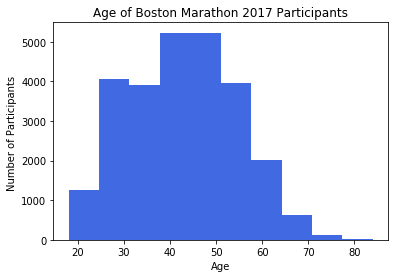

In [4]:
plt.hist(data.Age,color='royalblue')  #the age varies from 18 to 84 years old.
plt.title("Age of Boston Marathon 2017 Participants")
plt.xlabel("Age")
plt.ylabel("Number of Participants ")
plt.show()

Text(0.5,1,'Age and Gender of Boston Marathon 2017 Participants')

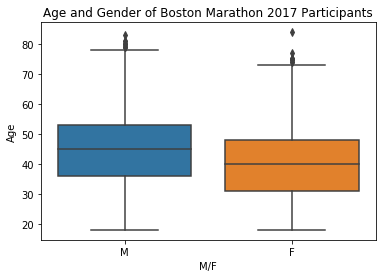

In [5]:
g = sns.boxplot(data['M/F'], data['Age'])
g.set_title("Age and Gender of Boston Marathon 2017 Participants")

### * Combine age and gender:

[Text(0,0.5,'Number of Participants'), Text(0.5,0,'Age')]

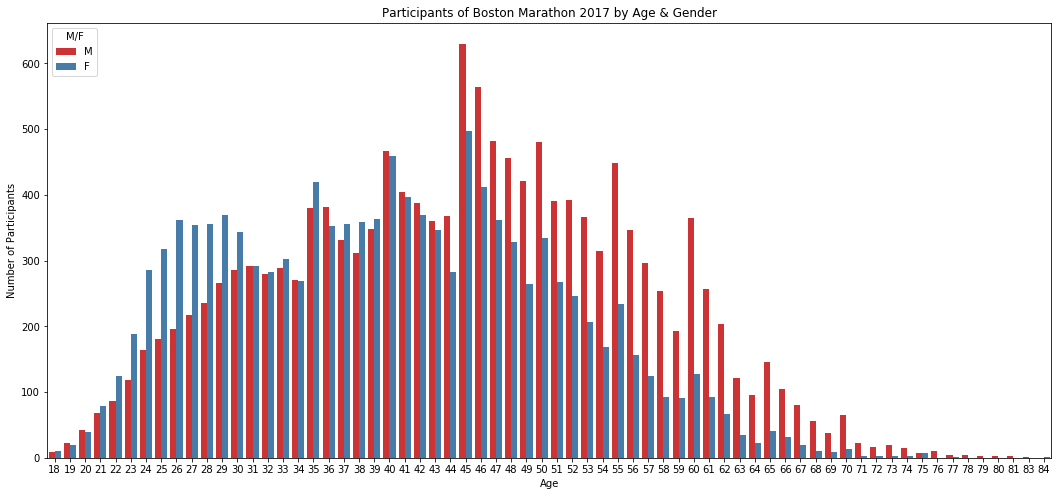

In [6]:
g = sns.countplot('Age', data=data, palette="Set1", hue='M/F')
g.figure.set_size_inches(18,8)
g.set_title("Participants of Boston Marathon 2017 by Age & Gender")
g.set(xlabel='Age', ylabel='Number of Participants')

In [7]:
#Calcualte mean of finish time for each age group
time = data.loc[:,['Time_Minutes','M/F']]
decade = pd.cut(data.Age,bins=np.arange(10,99,10),right=False)
time["DECADE"] = decade
summary = time.groupby('DECADE')['Time_Minutes'].mean()
#summary.index = np.arange(10,90,10) 
print(summary)   
#fastest group is 30-39 years old

DECADE
[10, 20)    255.197090
[20, 30)    232.576644
[30, 40)    228.135193
[40, 50)    235.063972
[50, 60)    246.556823
[60, 70)    265.788384
[70, 80)    292.434007
[80, 90)    296.754762
Name: Time_Minutes, dtype: float64


In [8]:
summary = time.groupby(['DECADE','M/F'])['Time_Minutes'].mean()
#print(summary)
summary = pd.DataFrame(summary)
summary = summary.reset_index()
print(summary)

      DECADE M/F  Time_Minutes
0   [10, 20)   F    273.472581
1   [10, 20)   M    237.492708
2   [20, 30)   F    244.571217
3   [20, 30)   M    213.696440
4   [30, 40)   F    240.370585
5   [30, 40)   M    215.243436
6   [40, 50)   F    249.068034
7   [40, 50)   M    223.601057
8   [50, 60)   F    260.858563
9   [50, 60)   M    238.666633
10  [60, 70)   F    282.248498
11  [60, 70)   M    260.690118
12  [70, 80)   F    306.417708
13  [70, 80)   M    289.738353
14  [80, 90)   F    364.116667
15  [80, 90)   M    285.527778


[Text(0,0.5,'Finishing Time (Minutes)'), Text(0.5,0,'Age Group')]

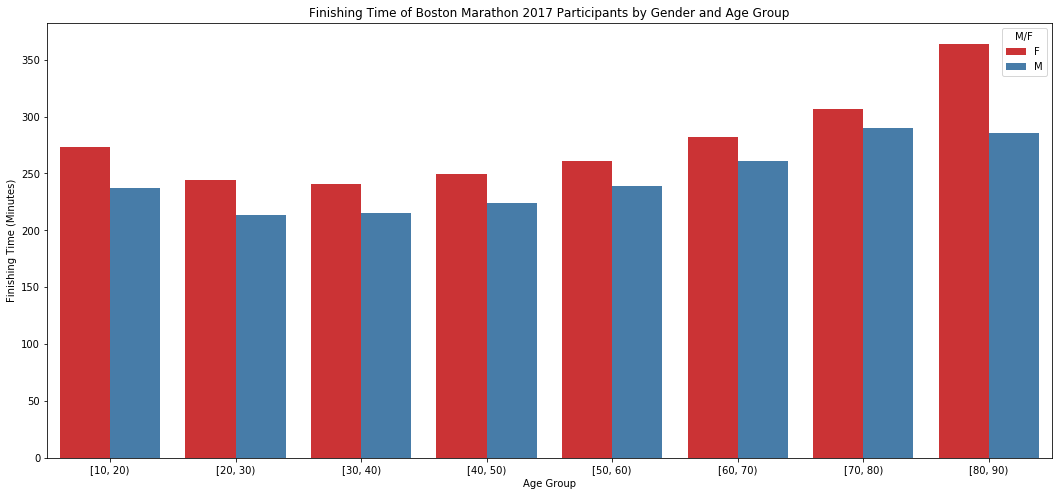

In [9]:
g = sns.barplot(x='DECADE', y='Time_Minutes',data=summary, palette="Set1", hue='M/F')
g.figure.set_size_inches(18,8)
g.set_title("Finishing Time of Boston Marathon 2017 Participants by Gender and Age Group")
g.set(xlabel='Age Group', ylabel='Finishing Time (Minutes)')

In [10]:
#test the difference in finish time for male and female
F = summary.loc[summary['M/F'] == 'F',['Time_Minutes']]
M = summary.loc[summary['M/F'] == 'M',['Time_Minutes']]

t_stat, p_val = stats.ttest_ind(F, 
                      M,
                      equal_var = False)
print(t_stat)
print(p_val)
#The differences in finish time is significant different at 10% significant levels.
#between participants from US and outside from US

[1.77668338]
[0.09940338]


### Finishing Time

#### Top 15 Fastest Countries

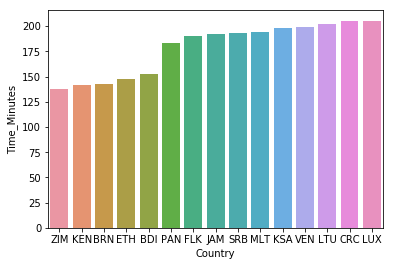

In [11]:
top_15_countries = data.groupby("Country")['Time_Minutes'].mean().nsmallest(15)

top15_countries = data.loc[data['Country'].isin(np.array(top_15_countries.index))]
top15_countries = top15_countries.groupby('Country')['Time_Minutes'].mean()
top15_countries = pd.DataFrame(top15_countries)
top15_countries = top15_countries.sort_values(['Time_Minutes'])
sns.barplot(x = top15_countries.index, y = top15_countries.Time_Minutes)

#### Worst 15 Countries

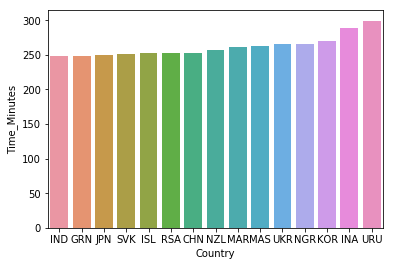

In [12]:
worst_15_countries = data.groupby("Country")['Time_Minutes'].mean().nlargest(15)

worst15_countries = data.loc[data['Country'].isin(np.array(worst_15_countries.index))]
worst15_countries = worst15_countries.groupby('Country')['Time_Minutes'].mean()
worst15_countries = pd.DataFrame(worst15_countries)
worst15_countries = worst15_countries.sort_values(['Time_Minutes'])
sns.barplot(x = worst15_countries.index, y = worst15_countries.Time_Minutes)

### Recode "Country" into Domestic US vs. International

In [13]:
data.Country.value_counts().head(10) #we can see there are many people are from USA.   

USA    20945
CAN     1870
GBR      425
MEX      285
CHN      242
GER      226
BRA      205
AUS      191
JPN      170
ITA      165
Name: Country, dtype: int64

In [14]:
#create new variable "US" as a categorical variable with level 1 and 0
data['US'] = np.where(data.Country.str.contains('USA'),1,0)
data[['Country','US']].head(10)

,Country,US
0,KEN,0
1,USA,1
2,JPN,0
3,USA,1
4,KEN,0
5,USA,1
6,USA,1
7,ETH,0
8,USA,1
9,USA,1


[Text(0,0.5,'Finishing Time'), Text(0.5,0,'Domestic/International')]

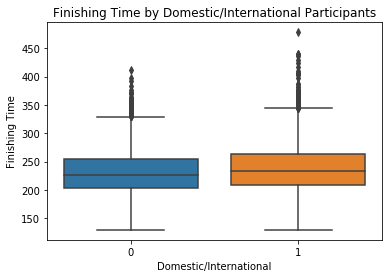

In [15]:
g = sns.boxplot(data['US'], data['Time_Minutes'])
g.set_title("Finishing Time by Domestic/International Participants")
g.set(xlabel = "Domestic/International", ylabel = "Finishing Time")
#domestic participants are slower than international participants

In [16]:
US = data.loc[:,['Time_Minutes','US']]
us_summary = US.groupby('US')['Time_Minutes'].mean()
us_summary2 = US.groupby('US')['Time_Minutes'].median()
print(us_summary)
print(us_summary2)
#from the mean and medain summary, 
#we can see people outside US perfom better then people from US
#since they use less time to finish the run.

US
0    231.786353
1    239.695991
Name: Time_Minutes, dtype: float64
US
0    226.416667
1    233.116667
Name: Time_Minutes, dtype: float64


In [17]:
#two sample t-test to see if the difference is significant or not.
from scipy import stats
US = data.loc[data.US == 1,['Time_Minutes','US']]
US.head()
nonUS = data.loc[data.US == 0,['Time_Minutes','US']]
nonUS.head()
t_stat, p_val = stats.ttest_ind(US, 
                      nonUS,
                      equal_var = False)
print(t_stat)
print(p_val)
#The differences in finish time is significant different 
#between participants from US and outside from US

[12.94862677         inf]
[5.19244219e-38 0.00000000e+00]


### Create "Region"

In [18]:
data.Country.unique()
# Africa : KEN, ETH, ZIM, BRN, BDI, RSA, EGY, MAR, ALG, NGR
# America : USA, MEX, BRA, CAN, COL, CRC, DOM, PAN, CHI, ARG, GUA, BER, CAY, FLK, VEN, JAM, HON, ECU, ESA, BAR, GRN,
# URU, PAR, TCA, TRI, 
# Asia : JPN, NZL, PER, AUS, MAS, PHI, SIN, CHN, TWN, HKG, IND, UAE, KOR, THA, ISR, KSA, NCA, INA, KUW, MGL, 
# Europe : ITA, NED, IRL, GBR, ESP, SUI, NOR, POL, FRA, RUS, POR, BEL, DEN, AUT, SLO, EST, TUR, SWE, FIN, LTU, GER, CRO,
# ISL, LUX, SRB, CZE, MLT, HUN, ROU, LAT, UKR, SMR, BUL, SVK, AND, GRE

array(['KEN', 'USA', 'JPN', 'ETH', 'ZIM', 'MEX', 'BRN', 'BRA', 'CAN',
       'ITA', 'NED', 'IRL', 'BDI', 'GBR', 'GER', 'ESP', 'SUI', 'COL',
       'NOR', 'POL', 'FRA', 'RUS', 'POR', 'CRC', 'BEL', 'NZL', 'PER',
       'DOM', 'PAN', 'AUS', 'DEN', 'MAS', 'PHI', 'CHI', 'AUT', 'ARG',
       'SIN', 'CHN', 'TWN', 'GUA', 'RSA', 'HKG', 'SLO', 'EST', 'TUR',
       'EGY', 'IND', 'UAE', 'SWE', 'BER', 'KOR', 'CAY', 'FIN', 'LTU',
       'GRE', 'CRO', 'ISL', 'LUX', 'FLK', 'VEN', 'JAM', 'THA', 'HON',
       'SRB', 'CZE', 'ISR', 'MLT', 'HUN', 'ECU', 'KSA', 'ESA', 'MAR',
       'ROU', 'LAT', 'UKR', 'SMR', 'BUL', 'ALG', 'NCA', 'SVK', 'AND',
       'BAR', 'INA', 'GRN', 'URU', 'PAR', 'TCA', 'KUW', 'TRI', 'MGL',
       'NGR'], dtype=object)

In [19]:
# Make Region
africa = ['KEN', 'ETH', 'ZIM', 'BRN', 'BDI', 'RSA', 'EGY', 'MAR', 'ALG', 'NGR']
america = ['USA', 'MEX', 'BRA', 'CAN', 'COL', 'CRC', 'DOM', 'PAN', 'CHI', 'ARG', 'GUA', 'BER', 'CAY', 'FLK', \
           'VEN', 'JAM', 'HON', 'ECU', 'ESA', 'BAR', 'GRN', 'URU', 'PAR', 'TCA', 'TRI']
asia = ['JPN', 'NZL', 'PER', 'AUS', 'MAS', 'PHI', 'SIN', 'CHN', 'TWN', 'HKG', 'IND',\
        'UAE', 'KOR', 'THA', 'ISR', 'KSA', 'NCA', 'INA', 'KUW', 'MGL']
europe = ['ITA', 'NED', 'IRL', 'GBR', 'ESP', 'SUI', 'NOR', 'POL', 'FRA', 'RUS', 'POR', 'BEL', 'DEN', 'AUT',\
          'SLO', 'EST', 'TUR', 'SWE', 'FIN', 'LTU', 'GER', 'CRO', 'ISL', 'LUX', 'SRB', 'CZE', 'MLT', 'HUN',\
          'ROU', 'LAT', 'UKR', 'SMR', 'BUL', 'SVK', 'AND', 'GRE']
data['Region'] = 'NA'

In [20]:
data.loc[data['Country'].isin(africa), 'Region'] = "Africa"
data.loc[data['Country'].isin(america), 'Region'] = "America"
data.loc[data['Country'].isin(asia), 'Region'] = "Asia"
data.loc[data['Country'].isin(europe), 'Region'] = "Europe"
data.Region.head(10)

0     Africa
1    America
2       Asia
3    America
4     Africa
5    America
6    America
7     Africa
8    America
9    America
Name: Region, dtype: object

Region
Africa     217.457333
America    238.234973
Asia       244.069313
Europe     232.837971
Name: Time_Minutes, dtype: float64


[Text(0,0.5,'Finishing Time'), Text(0.5,0,'Continent')]

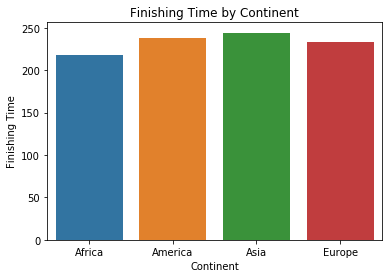

In [22]:
Region_time = data.groupby('Region')['Time_Minutes'].mean()
print(Region_time)
g = sns.barplot(x = Region_time.index, y = Region_time)
g.set_title("Finishing Time by Continent")
g.set(xlabel = "Continent", ylabel = "Finishing Time")

In [23]:
# Regions are significantly different.
stats.f_oneway(data[data['Region'] == "Africa"]['Time_Minutes'], data[data['Region'] == "America"]['Time_Minutes'], \
               data[data['Region'] == "Asia"]['Time_Minutes'], data[data['Region'] == "Europe"]['Time_Minutes'])

F_onewayResult(statistic=19.821127770662194, pvalue=7.905385082662423e-13)

### Data Modeling

In [24]:
# Making a dummy variables 

linear_model_data = pd.get_dummies(data, prefix='Gender', columns=['M/F'])
linear_model_data = pd.get_dummies(linear_model_data, prefix = 'Region', columns = ['Region'])
linear_model_data = pd.DataFrame(linear_model_data)
print(linear_model_data.head())

   Unnamed: 0 Bib              Name  Age           City State Country Citizen  \
0           0  11   Kirui, Geoffrey   24       Keringet   NaN     KEN     NaN   
1           1  17       Rupp, Galen   30       Portland    OR     USA     NaN   
2           2  23     Osako, Suguru   25   Machida-City   NaN     JPN     NaN   
3           3  21  Biwott, Shadrack   32  Mammoth Lakes    CA     USA     NaN   
4           4   9    Chebet, Wilson   31       Marakwet   NaN     KEN     NaN   

  Unnamed: 9       5K      ...      Gender Division Time_Minutes US Gender_F  \
0        NaN  0:15:25      ...           1        1   129.616667  0        0   
1        NaN  0:15:24      ...           2        2   129.966667  1        0   
2        NaN  0:15:25      ...           3        3   130.466667  0        0   
3        NaN  0:15:25      ...           4        4   132.133333  1        0   
4        NaN  0:15:25      ...           5        5   132.583333  0        0   

  Gender_M Region_Africa Region_

In [25]:
marathon_model = LinearRegression(fit_intercept= True)
X =linear_model_data.loc[:, ['Age', 'Gender_M', 'Region_Africa', 'Region_Asia', 'Region_America']]

Females and runners from Europe are our baseline for the categorical variables.

In [26]:
marathon_model.fit(X, np.log(linear_model_data.Time_Minutes))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
marathon_model.coef_

array([ 0.0047167 , -0.11209307, -0.10284686,  0.03066378,  0.01275562])

In [28]:
X2 = sm.add_constant(X)
est = sm.OLS(np.log(linear_model_data['Time_Minutes']), X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           Time_Minutes   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1021.
Date:                Tue, 12 Jun 2018   Prob (F-statistic):               0.00
Time:                        12:28:21   Log-Likelihood:                 11266.
No. Observations:               26410   AIC:                        -2.252e+04
Df Residuals:                   26404   BIC:                        -2.247e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3055      0.005    969.

All of variables are significant, but our R^2 is pretty low. We have checked whether any violation exsited. 

In [29]:
vif = [variance_inflation_factor(X2.values, i) for i in range(1,X2.shape[1])]
print(vif)

[1.0539069817661397, 1.0592283476721205, 1.026820917216397, 1.5131960232547403, 1.5592925443953225]


It seems that there is no multicollinearity problem. All of variance inflation factor is not greater than 5.

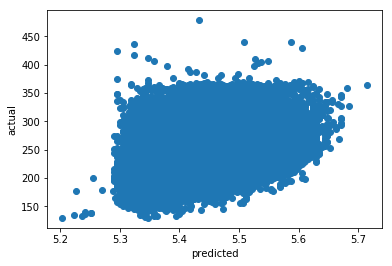

In [30]:
yhat = marathon_model.predict(X)
plt.plot(yhat, data.Time_Minutes, 'o')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

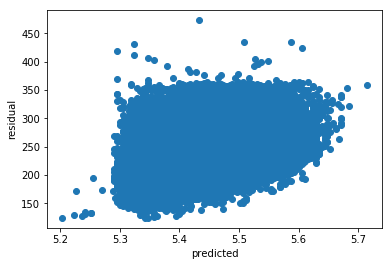

In [31]:
residuals = data.Time_Minutes - yhat
plt.plot(yhat, residuals, 'o')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.show()

Residual plot doesn't seem to be okay. It is not randomly distributed, but there are chunky in the middle of predicted values.

In [1]:
plt.plot(linear_model_data['Age'], linear_model_data['Time_Minutes'], 'o')
plt.xlabel('Age')
plt.ylabel('Official time')
plt.show()

NameError: name 'plt' is not defined

Age and official time is not linear relationship. The slope is different at some points. To overcome this problem, we move on Generlized Additive Model.

In [33]:
gam = LinearGAM(n_splines=10).gridsearch(X, np.log(data['Time_Minutes']))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [34]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.6362
Link Function:                     IdentityLink Log Likelihood:                               -470626.8656
Number of Samples:                        26410 AIC:                                           941281.0035
                                                AICc:                                          941281.0186
                                                GCV:                                                0.0243
                                                Scale:                                              0.0242
                                                Pseudo R-Squared:                                   0.1863
Feature Function   Data Type      Num

GAM suggests that Age should be split into 3 parts, and other variables stay the same. We can see that R^2 is bit improved and all other variables are significant.

In [35]:
# train & test
X_train, X_test, y_train, y_test = train_test_split(X, np.log(data['Time_Minutes']), test_size=0.3, random_state=42)

In [36]:
marathon_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
yhat_lm = marathon_model.predict(X_test)
mse_lm = ((y_test - yhat_lm) ** 2).mean()
print(mse_lm)
print(np.exp(0.024883640233079506))

0.02488364023307956
1.0251958220368913


In [38]:
gam = LinearGAM(n_splines=10).gridsearch(X_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [39]:
yhat_gam = gam.predict(X_test)
mse_gam = ((y_test - yhat_gam) ** 2).mean()
print(mse_gam)
print(np.exp(0.024224091350402783))

0.02422409135040276
1.0245198782114426


We can see that GAM doing better than linear regression.

### Further Analysis: Random Forest to Predict finish time based on Gender, Age, and Region

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data_RF = data.loc[:,['Age','M/F','Region','Time_Minutes']]
data_RF.head()

/Users/ruthyzheng/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ruthyzheng/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,Age,M/F,Region,Time_Minutes
0,24,M,Africa,129.616667
1,30,M,America,129.966667
2,25,M,Asia,130.466667
3,32,M,America,132.133333
4,31,M,Africa,132.583333


In [41]:
features = pd.get_dummies(data_RF)
labels = features['Time_Minutes']
features = features.drop('Time_Minutes',axis=1)
feature_list = list(features.columns)
features = np.array(features)
labels = np.array(labels)
#training and testing
train_features,test_features,train_labels,test_labels = train_test_split(features,
                                                                         labels,
                                                                         test_size=0.25,
                                                                         random_state=42)
print("Training Features  shape: ", train_features.shape)
print("Training Labels shape: ", train_labels.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Features Shape: ",test_labels.shape)

Training Features  shape:  (19807, 7)
Training Labels shape:  (19807,)
Testing Features Shape:  (6603, 7)
Testing Features Shape:  (6603,)


In [42]:
rf_exp = RandomForestRegressor(n_estimators=1000,random_state=100)
rf_exp.fit(train_features,train_labels)



predictions = rf_exp.predict(test_features)
error = abs(predictions-test_labels)
meanError = np.mean(100*(error/test_labels))
accuracy = 100 - meanError
print('Accuracy:',round(accuracy,2),'%.')

Accuracy: 87.62 %.
